# Sheet 2

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

## 1 Kernel Density Estimation
(a)

In [2]:
def biweight(x, mu, w):
    """Biweight kernel at mean mu, with bandwidth w, evaluated at x."""
    #TODO: implement the quartic (biweight) kernel

    u = (x - mu) / w
    mask = np.abs(u) < 1
    return mask * (15 / 16) * (1 - u**2)**2 / w 
    

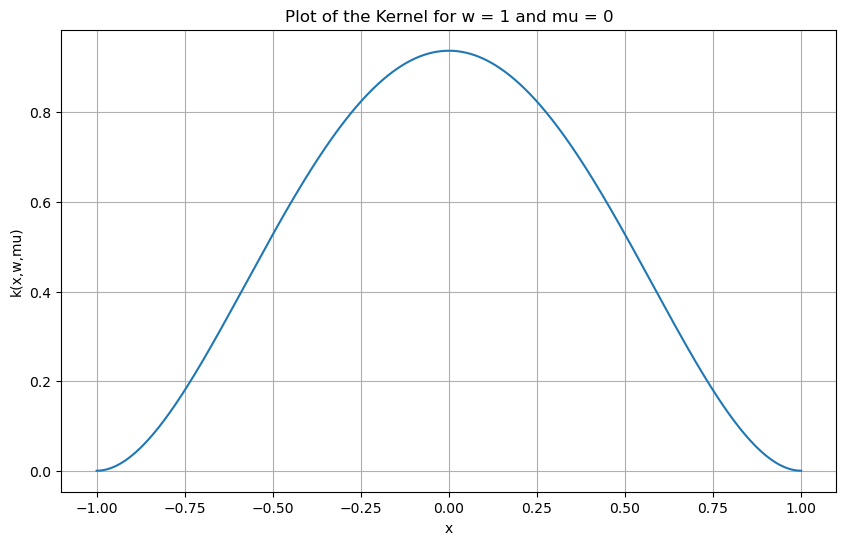

In [3]:
# TODO plot the kernel

interval = np.linspace(-1, 1, 1000)
kernel = biweight(interval, 0, 1)

plt.figure(figsize=(10, 6))
plt.plot(interval, kernel, linestyle="-")
plt.title("Plot of the Kernel for w = 1 and mu = 0")
plt.xlabel("x")
plt.ylabel("k(x,w,mu)")
plt.grid(True)
plt.show()

(b)

In [4]:
# load the data
data = np.load("data/samples.npy")
data50 = data[:50]
print(f'{data.shape=}, {data50.shape=}')

data.shape=(10000,), data50.shape=(50,)


In [5]:
def kde(x, obs, w=1):
    # TODO: implement the KDE with the biweight kernel

    density = np.sum([biweight(x, mu, w) for mu in obs], axis=0) / len(obs)
    return density

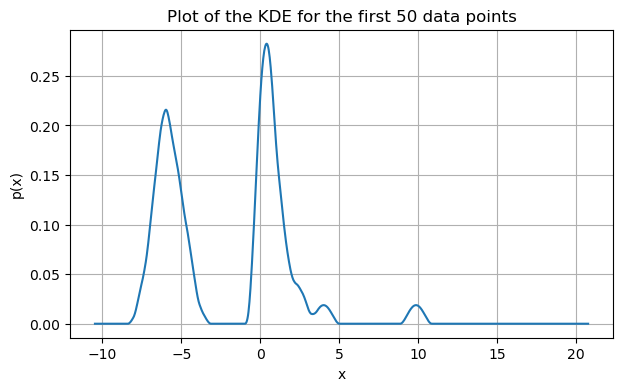

In [6]:
# TODO: compute and plot the kde on the first 50 data points

x_values = np.linspace(min(data) - 1, max(data) + 1, 1000)

kde_values_50 = kde(x_values, data50, w=1) 

plt.figure(figsize=(7,4))
plt.plot(x_values, kde_values_50, linestyle="-")
plt.title("Plot of the KDE for the first 50 data points")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.show()

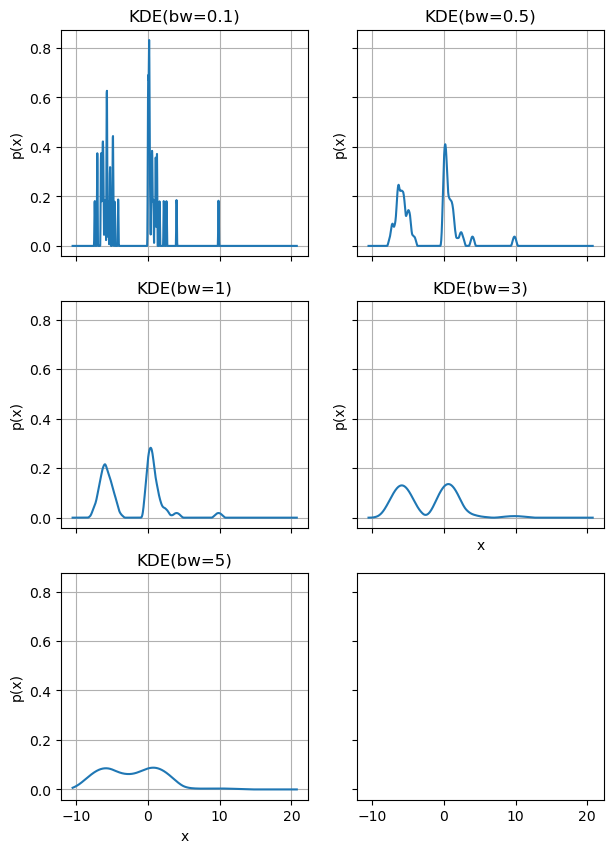

In [7]:
# TODO: explore the influence of bandwidth

x_values = np.linspace(min(data) - 1, max(data) + 1, 1000)

fig, axes = plt.subplots(3,2, figsize = (7, 10), sharey=True, sharex=True,)
axes = axes.flatten()
for ax, bandwidth in zip(axes, (0.1, 0.5, 1, 3, 5)):
    kde_values_50 = [kde(x, data50, w=bandwidth) for x in x_values]

    ax.plot(x_values, kde_values_50, linestyle="-")
    ax.set_title(f"KDE(bw={bandwidth})")
    
    if bandwidth >=3: ax.set_xlabel("x")
    ax.set_ylabel("p(x)")

    ax.grid(True)


We observe that low bandwidths overfit the data, whereas high bandwidths wash out structure of the data. We deem $w=1$ to be optimal for the sample since the resulting distribution is very smooth with few local minima which could be a useful computational property depending on usecase, while retaining as much stucture as possible.

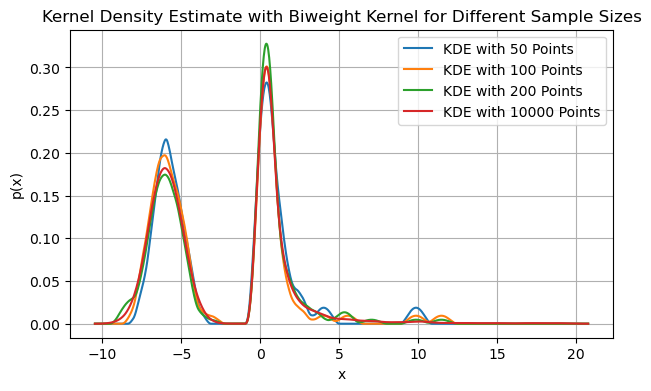

In [8]:
# TODO: explore what happens when you increase the number of points
plt.figure(figsize=(7, 4))
bandwidth = 1 

for n in [50, 100, 200, len(data)]:
    data_n = data[:n]
    kde_values_n = kde(x_values, data_n, w=bandwidth)
    plt.plot(x_values, kde_values_n, label=f"KDE with {n} Points", linestyle="-")


plt.title("Kernel Density Estimate with Biweight Kernel for Different Sample Sizes")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.grid(True)
plt.legend()
plt.show()

## 2 Average shifted Histograms (ASH) and KDE
(a)

We consider first the one dimensional histogram with bins of width $b$ centered at the observation $x_0$ and derive an expression for the shape of the kernel $p(x)$ given a continuous random variable $s \in \mathbb{R}$ with some probability distribution $s\sim \mathbb{P}$. The probability for the shifted bin to contain $x$ is given by the expected value
$$p(x) = \mathbb{P}(x_0 + x + s \in [x_0 - \frac{b}{2}, x_0 + \frac{b}{2}])$$
$$= \mathbb{P}(s + x \in [-\frac{b}{2}, \frac{b}{2}]) =\mathbb{P}(-\frac{b}{2}- x \le s \le \frac{b}{2}-x)$$
$$= \mathrm{CDF}_{\mathbb{P}}(b/2-x) - \mathrm{CDF}_{\mathbb{P}}(-b/2-x)$$
For instance, a uniformly sampled offset will lead to a triangle-shaped kernel.

We can see that ASH converges to KDE as $h \rightarrow \infty$ by finding an expression for $p$ at finite $h$ and showing equivalence:
$$p_h(x) = \frac{1}{h}\sum_{n=1}^h \int_{Supp(s)} \mathrm{d}s ~\left(f_{\mathbb{P}}(s) {\mathbb{1}_{[-b/2-x, b/2-x]}(s)}\right)$$
$$= \int_{Supp(s)} \mathrm{d}s ~\left(f_{\mathbb{P}}(s) \frac{1}{h}\sum_{n=1}^h {\mathbb{1}_{[-b/2-x, b/2-x]}(s)}\right)$$
$$= \int_{Supp(s)} \mathrm{d}s ~\left(f_{\mathbb{P}}(s)  \mathbb{1}_{[-b/2-x, b/2-x]}(s)\right)$$
$$= \int_{[-b/2-x, b/2-x]} \mathrm{d}s ~\left(f_{\mathbb{P}}(s) \right) = p ~~\square$$


(b), (c)

Consider a bin area $A$ that tiles the plane. We can find an expression for the kernel $p(x_1, x_2) = p(x)$ with random shift $s = (s_1, s_2); ~~s_1, s_2 \stackrel{i.i.d}{\sim} \mathbb{P}$ as above, namely by computing the expected value.
$$p(x_1, x_2) = \int_{Supp(s)} f_{\mathbb{P}}(s_1+x_1)f_{\mathbb{P}}(s_2+x_2)\mathbb{1}_A(s+x) \mathrm{d}s_1\mathrm{d}s_2$$
$$= \int_A f_{\mathbb{P}}(s_1+x_1)f_{\mathbb{P}}(s_2+x_2) \mathrm{d}s_1\mathrm{d}s_2$$
For the axis-aligned rectangle$A = R = \{(x_1, x_2) \in \mathbb{R}^2: -w/2 \le x_1 \le w/2, -l/2 \le x_2 \le l/2)\}$ the expression simplifies to
$$p(x_1, x_2) = \int_R f_{\mathbb{P}}(s_1+x_1)f_{\mathbb{P}}(s_2+x_2) \mathrm{d}s_1\mathrm{d}s_2$$ 
$$ = \int_{[-w/2-x_1, w/2-x_1]\times[-l/2-x_2, l/2-x_2]} f_{\mathbb{P}}(s_1)f_{\mathbb{P}}(s_2) \mathrm{d}s_1\mathrm{d}s_2$$
$$=\left[CDF_{\mathbb{P}}(w/2-x_1) - CDF_{\mathbb{P}}(-w/2-x_1)\right]\left[CDF_{\mathbb{P}}(l/2-x_2) - CDF_{\mathbb{P}}(-l/2-x_2)\right] $$
due to the independence of the integral boundaries.

## 3 Mean-Shift
(a)

The update rule reads $$x_j^{t+1} = x_j^t + \alpha_j^t \frac{2}{n}\sum_{i: ~||x_i - x_j^t|| < 1} x_i - x_j^t.$$
Goal: update to the equivalent of moving to the local mean of points within the kernel support.
Idea: set $\alpha_j^t$ so that update vector maps $x_j^t$ directly to the mean of nearby points.
$$N_j = \sum_{i: ~||x_i - x_j^t|| < 1} 1$$
$$\mathrm{local ~~mean} = \frac{1}{N_j} \sum_{i: ~||x_i - x_j^t|| < 1} x_i$$
$$\iff \mathrm{local ~~ mean} - x_j^t = \frac{1}{N_j} \sum_{i: ~||x_i - x_j^t|| < 1} x_i - x_j^t$$
$$x_j^{t+1} = x_j^t + \alpha_j^t \frac{2}{n} N_j \left(\frac{1}{N_j} \sum_{i: ~||x_i - x_j^t|| < 1} x_i - x_j^t\right)$$
$$= x_j^t + \alpha_j^t \frac{2 N_j}{n} (\mathrm{local ~~mean} - x_j^t)$$
$$\implies \alpha_j ^t = \frac{n}{2N_j}$$
sensible because:
* learning rate adapts to the local density of points nearby -> small step size and *vice versa*.
* ensures that $x_j^t$ is moved directly to the mean of nearby points -> convergence to lower moves.

(b)

In [9]:
# TODO: implement the update to the local mean

def mean_shift_step(x, xt, r=1):
    """
    A single step of mean shift, moving every point in xt to the local mean of points in x within a radius of r.
    
    Parameters
    ----------
    x : np.ndarray
        Array of points underlying the KDE, shape (N1,)
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (N2,)
    r : float, optional
        Radius defining the neighborhood for the KDE, by default 1.
        
    Returns
    -------
    np.ndarray
        The points after the mean-shift step.
    """
    # Ensure x and xt have the same dimensionality
    assert xt.ndim == 1 and x.ndim == 1, "This function only supports 1D data for this exercise."
    
    # Calculate pairwise distances between each point in xt and all points in x
    dists = np.abs(x[:, np.newaxis] - xt)  # Shape (N1, N2)
    
    # Initialize an array for local means
    local_means = np.zeros_like(xt)
    
    # For each point in xt, compute the local mean of neighbors within radius r
    for j in range(len(xt)):
        # Find neighbors within radius r
        neighbors = x[dists[:, j] < r]
        
        # Calculate the mean of neighbors or retain point if no neighbors are within radius
        if len(neighbors) > 0:
            local_means[j] = np.mean(neighbors)
        else:
            local_means[j] = xt[j]  # No shift if no neighbors within radius
    
    return local_means

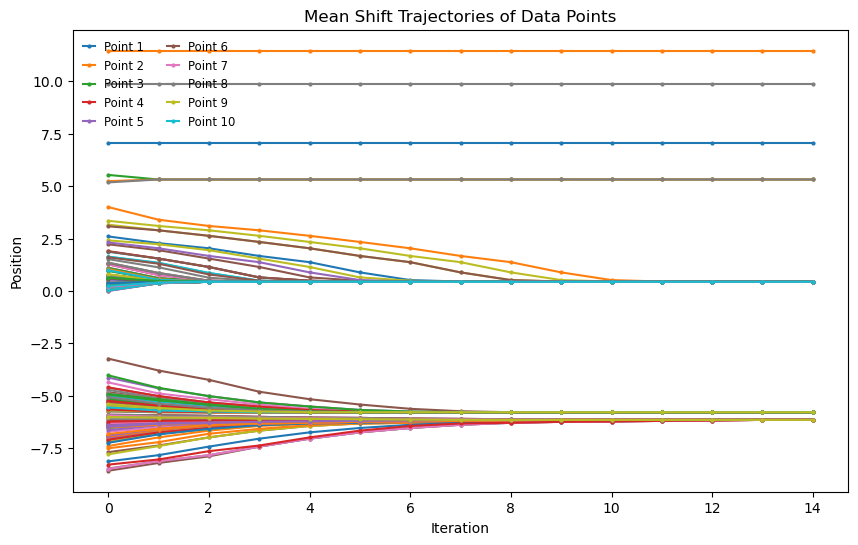

In [10]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    
    # TODO: update xt with your mean shift step

    xt = mean_shift_step(x, xt, r=1)  
    trajectories.append(xt.copy())
    

    if np.allclose(trajectories[-1], trajectories[-2], atol=1e-3):
        break

trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1


# TODO: plot the trajectories

plt.figure(figsize=(10, 6))
for i in range(xt.shape[0]):
    plt.plot(trajectories[:, i], label=f'Point {i+1}' if i < 10 else "", marker='o', markersize=2)
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.title('Mean Shift Trajectories of Data Points')
plt.legend(loc="upper left", ncol=2, fontsize='small', handlelength=1, frameon=False)
plt.show()


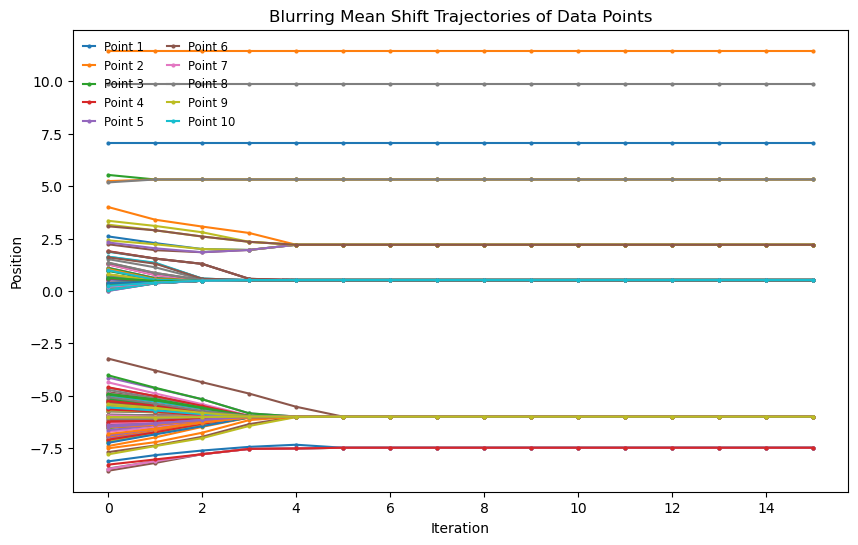

In [11]:
# TODO: repeat the above for "blurring" mean shift

def blurring_mean_shift_step(xt, r=1):
    """
    A single step of blurring mean shift, where every point in xt is moved to the local mean 
    of other points in xt within a radius of r.
    
    Parameters
    ----------
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (N,)
    r : float, optional
        Radius defining the neighborhood for the KDE, by default 1.
        
    Returns
    -------
    np.ndarray
        The points after the blurring mean-shift step.
    """
    # Calculate pairwise distances between points in xt
    dists = np.abs(xt[:, np.newaxis] - xt)  # Shape (N, N)
    
    # Initialize an array for local means
    local_means = np.zeros_like(xt)
    
    # For each point in xt, compute the local mean of neighbors within radius r
    for j in range(len(xt)):
        # Find neighbors within radius r in the current state of xt
        neighbors = xt[dists[:, j] < r]
        
        # Calculate the mean of neighbors or retain point if no neighbors are within radius
        if len(neighbors) > 0:
            local_means[j] = np.mean(neighbors)
        else:
            local_means[j] = xt[j]  # No shift if no neighbors within radius
    
    return local_means

# Run blurring mean shift
xt_blur = x.copy()
trajectories_blur = [xt_blur.copy()]
max_steps = 15

for step in range(max_steps):
    xt_blur = blurring_mean_shift_step(xt_blur, r=1)  # Update xt with blurring mean shift step
    trajectories_blur.append(xt_blur.copy())
    
    # Check for convergence
    #if np.allclose(trajectories_blur[-1], trajectories_blur[-2], atol=1e-3):
    #    break

# Convert list of trajectories to numpy array for easy indexing
trajectories_blur = np.stack(trajectories_blur)
n_steps_blur = len(trajectories_blur) - 1

# Plotting the blurring mean shift trajectories
plt.figure(figsize=(10, 6))
for i in range(xt_blur.shape[0]):
    plt.plot(trajectories_blur[:, i], label=f'Point {i+1}' if i < 10 else "", marker='o', markersize=2)
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.title('Blurring Mean Shift Trajectories of Data Points')
plt.legend(loc="upper left", ncol=2, fontsize='small', handlelength=1, frameon=False)
plt.show()


Mean shift converged after approximately ten iterations whereas blurred mean shift conveged after seven. Thus BMS converges faster in terms of iterations. The total runtime however also depends on the complexity of each step hence it is unclear if BMS is truly faster due to the added complexity of blurring compared to MS. 
Regarding the quality of clusters, we think that MS is superior since it produces large clusters in areas of many data points. The same cannot be said about BMS since our results here show formation of multiple small clusters which, judging from the trajectories, seem to be too unable to merge due their masses being blurred. From the POV of the algorithm, the clusters are already undistinguishable. This could be fixed by lowering the blurring range but here we want to emphatize the susceptibility of the method to the choice of hyperparameters. The outliers are treated in the same way by both update rules.

## 4 On KDE Bandwidth and Modes 
The statement in the exercise sheet is true and cannot be disproven, cf. Silverman 1981, Theorem 1: https://sites.stat.washington.edu/wxs/Stat593-s03/Literature/silverman-81a.pdf

As for the strictly-monotonous case, consider two points $x_1 = x_2$. Indeed, the number of modes will always be one, thus not strictly monotonously decreasing. 

However, the number of modes can empirically be used to determine a decent value for the bandwidth as one observes an elbow or kink in the number of modes as a function of bandwidth.

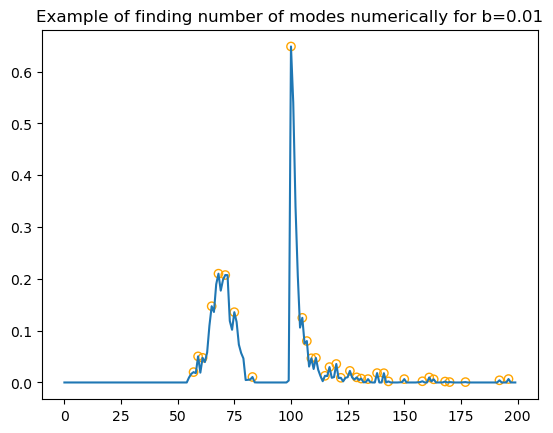

In [12]:

data1000 = data[:1000]
pdf = gaussian_kde(data1000, bw_method=0.01)
values = pdf(np.linspace(-20, 20, 200))
from scipy.signal import find_peaks
peak_info= find_peaks(values)
plt.plot(values)
plt.scatter(peak_info[0], values[peak_info[0]], marker="o", facecolors="none", edgecolors="orange")
plt.title("Example of finding number of modes numerically for b=0.01");

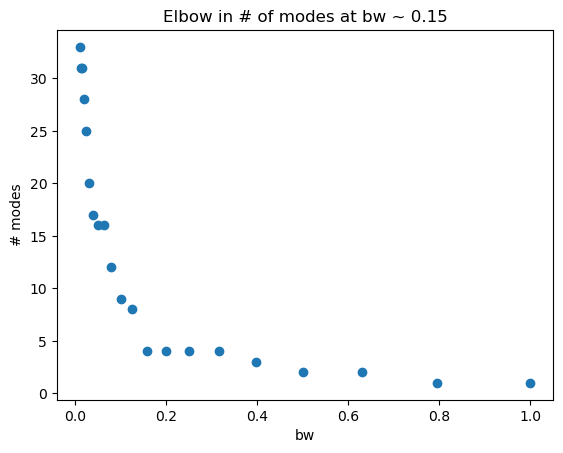

In [13]:
n_modes = list()
bws = np.logspace(-2, 0, 21)
for bandwidth in bws:
    
    pdf = gaussian_kde(data1000, bw_method=bandwidth)
    values = pdf(np.linspace(-20, 20, 200))
    peak_info = find_peaks(values)
    n_modes.append(len(peak_info[0]))

plt.scatter(bws, n_modes)

plt.ylabel("# modes")
plt.xlabel("bw")
plt.title("Elbow in # of modes at bw ~ 0.15");


## 5 Linear Regression: Heteroscedastic Noise

The case of heteroscedastic noise can be treated using 
$$y_n = {\beta}^T\mathbf{x}_n + \epsilon_n $$
and minimizing the weighted sum of square of residuals
$$J({\beta}) = \sum_{n=1}^N (y_n - {\beta}^T\mathbf{x}_n)^2 \rightarrow \sum_{n=1}^N (y_n - {\beta}^T\mathbf{x}_n)^2 / \sigma_n^2.$$ 
Observations with lower variance contribute more to the determination of the coefficients ${\beta}$ than the ones with higher variance. By minimizing $J({\beta})$ we find the best estimate.
$$\hat{{\beta}} = (\mathbf{x^TWx})^{-1} \mathbf{x^T Wy}$$ 
with $W_{nn} = 1/\sigma_n^2$ diagonal, responses $\mathbf{y}$ and predictors $\mathbf{x}$.
$$Cov(A Y)= A Cov(Y) A^T; ~~~~Cov(\mathbf{y}) = Cov(\mathbf{x}{\beta} + \mathbf a) = Cov(\mathbf{a}) = diag(\sigma_1^2, \ldots, \sigma_n^2) = {\sigma}^2 \mathbb{1}$$
$$\implies Cov({\hat{{\beta}}}) = (\mathbf{x^T Wx})^{-1} \mathbf{x^T W}Cov(\mathbf{y}\mathbf{Wx}) (\mathbf{x^T Wx})^{-1}$$
$$ = (\mathbf{x^T Wx})^{-1} \mathbf{x^T WWx} (\mathbf{x^T Wx})^{-1} a^2$$
$$ = a^2(\mathbf{x^T Wx})^{-1}.$$
$a^2$ is a scaling factor, this accounts for the different variances.
